In [1]:
import sys
import os

REPO_DIR = os.path.join(os.getcwd(), "../../")
os.chdir(REPO_DIR)

from src.lib.metient import *
from src.util import data_extraction_util as dutil

import matplotlib
import torch
import pandas as pd
import numpy as np

custom_colors = ["#9e9e9e","#c27ba0", "#be5742e1", "#6fa8dc", "#e69138", "#6aa84f"]
TRACERX_DATA_DIR = os.path.join(REPO_DIR, 'src/data/tracerx_nsclc/')
PYCLONE_CLUSTERED_TSVS_DIR = os.path.join(TRACERX_DATA_DIR, 'patient_data', 'pyclone_clustered')
CONIPHER_TREES_DIR = os.path.join(TRACERX_DATA_DIR, 'conipher_outputs', 'TreeBuilding')
OUTPUT_DIR = os.path.join(TRACERX_DATA_DIR, "metient_outputs")

CUDA GPU: False


In [2]:
def find_labeling(ref_var_fn, tree, custom_colors, primary_site, patient_name, output_dir, weights):    
    ref_matrix, var_matrix, unique_sites, idx_to_full_cluster_label = get_ref_var_matrices(ref_var_fn)

    idx_to_cluster_label = dict()
    for ix in idx_to_full_cluster_label:
        og_label_muts = idx_to_full_cluster_label[ix].split(';') # e.g. CUL3:2:225371655:T;TRPM6:9:77431650:C
        if len(og_label_muts) > 3:
            og_label_muts = og_label_muts[:3]
        gene_names = []
        for mut_label in og_label_muts:
            gene_names.append(mut_label.split(":")[0])
        idx_to_cluster_label[ix] = ("_").join(gene_names)
    print(idx_to_cluster_label)
    print(tree.shape)
    G = get_genetic_distance_matrix_from_adj_matrix(tree,idx_to_full_cluster_label, ";")
    print(G)
    if weights.gen_dist == 0.0:
        G = None
    
    print(f"Anatomical sites: {unique_sites}")   

    print_config = PrintConfig(visualize=True, verbose=False, viz_intermeds=False, k_best_trees=10)
    get_migration_history(tree, ref_matrix, var_matrix, unique_sites, primary_site, idx_to_cluster_label,
                          weights, print_config, output_dir, patient_name, G=G, O=None,
                          weight_init_primary=True, custom_colors=custom_colors, 
                          batch_size=6000, max_iter=80, solve_polytomies=False, mode='calibrate')

    
def run_conipher_patient(patient, weights, tsv_dir, tree_dir, output_dir):
    space = "x"*44
    tsv_fn = os.path.join(tsv_dir, f"{patient}_clustered_SNVs.tsv")
    print(f"{space} PATIENT {patient} {space}")
    df = pd.read_csv(tsv_fn, delimiter="\t")
    primary_sites = list(df[df['sample_type']=='primary']['anatomical_site_label'].unique())
    if (len(primary_sites) > 1):
        print("*Multiple primary samples, running metient once for each possible primary*")
    for primary_site in primary_sites:
        print(f"Primary site: {primary_site}")
        run_name = f"{patient}_{primary_site}"
        tree_fn = os.path.join(tree_dir, f"{patient}_conipher_SNVsallTrees_cleaned.txt")
        trees = dutil.get_adj_matrices_from_all_conipher_trees(tree_fn)
        find_labeling(tsv_fn, trees[0], custom_colors, primary_site, run_name, output_dir, weights)


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx PATIENT CRUK0590 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Primary site: primary_SU_T1
{0: 'LILRB5_SORCS1_ZNF487', 1: 'MYH1_INTS2_FAM90A27P', 2: 'DDX18_IL1RN_ASH1L', 3: 'GATA4_CDADC1_SPAG9', 4: 'MUC16_NCAPD2_MYOM1', 5: 'ENPP1_OGN_ADAMTS12', 6: 'OVGP1_MGA_NELFCD', 7: 'AGXT2_LMLN_RPL37', 8: 'TMEM72_SLC2A6_C8orf37', 9: 'COL11A1_SOCS2_OSBPL2', 10: 'FRMD4A_CAMK1G_ANKRD33', 11: 'LTBP2_GPNMB_TONSL', 12: 'PLXNA4_C1R_MORN1', 13: 'SNTG2_STIL_MAST3', 14: 'AGRN_LATS2_KRT77', 15: 'WBSCR17_ADRA1A_SYT1', 16: 'COL27A1_SOBP_USP31'}
torch.Size([17, 17])
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0466, 0.0000,
         0.0000, 0.0292, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2915, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.

/lila/data/morrisq/divyak/projects/met_history_prediction/src/util/vertex_labeling_util.py:259: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A.T, remove_self_loops=False), dtype = torch.float32)


X torch.Size([6000, 5, 16])
nodes_w_children [0, 1, 2, 3, 4, 8, 10, 11, 12, 13, 15, 16] sites [[0, 1, 2, 3, 4], [3], [3], [4], [1, 2], [1], [0, 1, 2, 3, 4], [0], [3], [2], [3], [1, 2, 3, 4]]
p tensor([[0],
        [0],
        [0],
        [0],
        [1]]) prim_site_idx tensor(4)
X tensor([[0.8313, 0.0401, 0.6060, 0.9486, 0.6578, 0.9447, 0.2311, 0.2300, 0.2392,
         4.0000, 4.0000, 0.6400, 0.7844, 0.9972, 0.9725, 0.7224],
        [0.7603, 0.3836, 0.8084, 4.0000, 0.3470, 0.8791, 0.7469, 4.0000, 0.0973,
         4.0000, 0.2868, 0.1843, 0.7557, 0.5469, 0.9376, 4.0000],
        [0.1752, 0.9981, 0.6648, 4.0000, 0.1934, 0.6691, 0.6413, 0.8962, 0.6427,
         4.0000, 0.3981, 0.7412, 4.0000, 0.6148, 0.3820, 4.0000],
        [4.0000, 4.0000, 0.3695, 0.3195, 0.7658, 0.0166, 0.3001, 0.9303, 0.0332,
         4.0000, 0.7986, 4.0000, 0.8797, 0.7371, 4.0000, 4.0000],
        [2.0000, 2.0000, 4.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
         4.0000, 2.0000, 2.0000, 2.0000, 2.000

  0%|          | 0/80 [00:00<?, ?it/s]/lila/data/morrisq/divyak/projects/met_history_prediction/src/util/vertex_labeling_util.py:250: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(get_path_matrix(A, remove_self_loops=True), dtype = torch.float32)
100%|██████████| 80/80 [00:26<00:00,  3.06it/s]


num solutions 6000
torch.Size([5, 1])
best_sums [17.0, 18.0]
bs 6000
pruned solutions 472


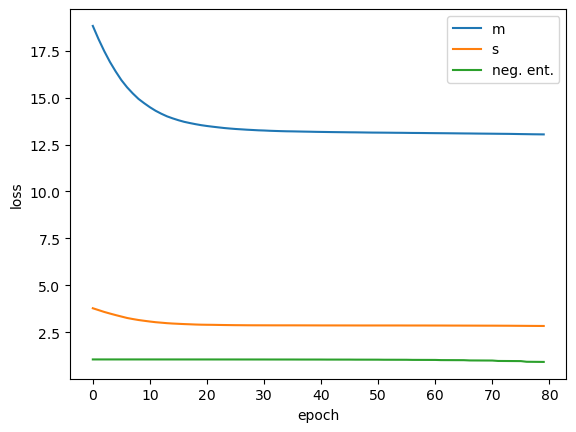

10 unique trees were not found (8 were found). Retry with a higher sample size if you want to get more trees.


<Figure size 640x480 with 0 Axes>

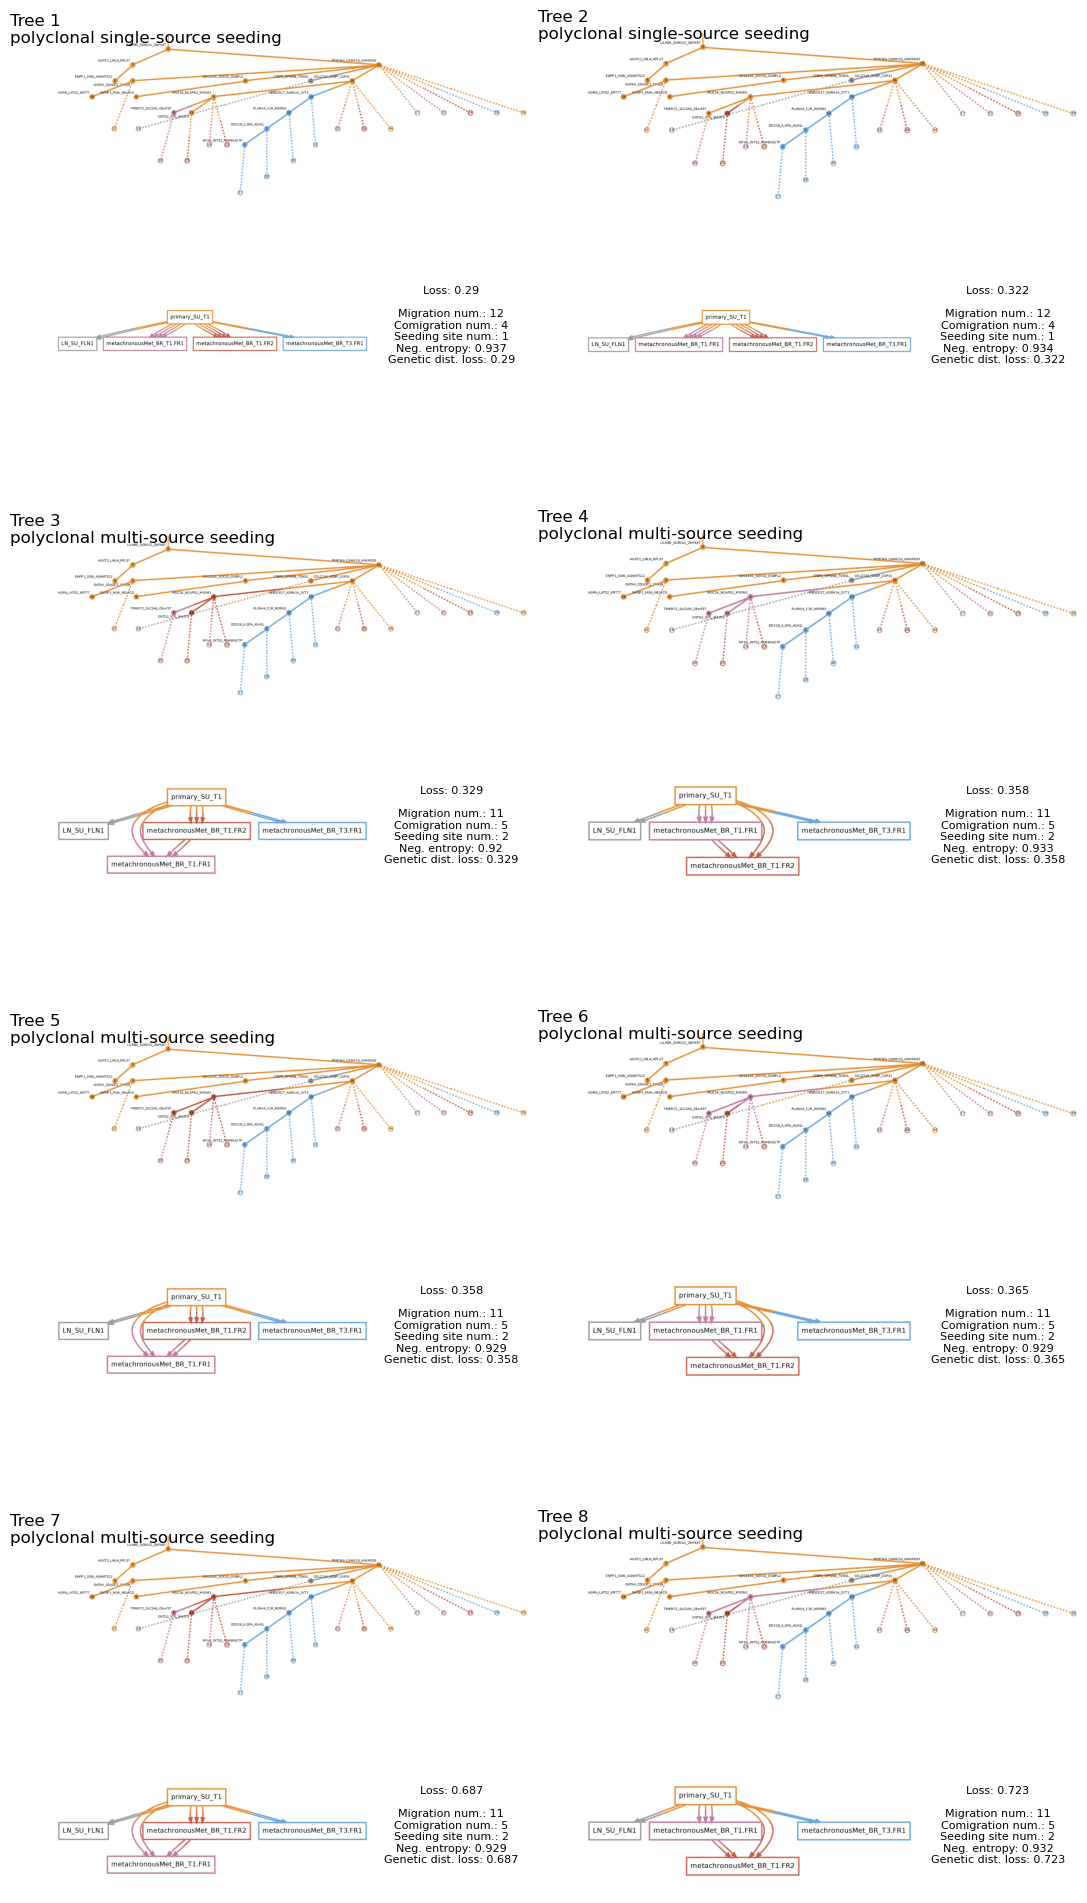

In [3]:
weights = Weights(mig=[5,4,3,2,1,1], mig_delta=0.8, seed_site=[1,1,1,1,1,2], gen_dist=1.0, organotrop=0.0)

run_conipher_patient("CRUK0590", weights, PYCLONE_CLUSTERED_TSVS_DIR, CONIPHER_TREES_DIR, OUTPUT_DIR)